# EDA - 1
Explore the relationship between the _sentiment in comments_ and _review scores in different aspects like description accuracy, clealiness, location, communcation, etc._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import geopandas as gpd

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../../Datasets/cleaned_senti_reviews.csv').iloc[:,1:]
df.head()

,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,host_since,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,2010-10-20,...,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,2,0.02
1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30
2,15222393,50646,2014-06-05,Welli,Stayed over at Sujatha's house for 3 good nigh...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30
3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30
4,817532,50646,2014-07-08,Jake,"We had a great experience. A nice place, an am...",Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,1,0.30


In [6]:
df.columns

Index(['reviewer_id', 'listing_id', 'date', 'reviewer_name', 'comments',
       'name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores

In [88]:
# The sentiment scores are acquired from the previous data preparation step.
df_review = df[['polarity_score','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]

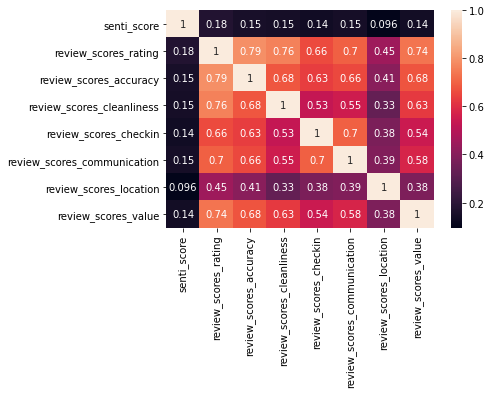

In [89]:
corrMatrix = df_review.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### It can be seen that there exists moderate correlation between sentiment score in comments and review scores, especially the review_score_rating.
The review score rating is presumed to be the overall score for the house by that reviewer. <br>
To make a more rigorous evaluation, we regressed the sentiment score on all other review scores.

In [13]:
# Utility method for linear regression and its summary.
def linear_model(X,y):
    import statsmodels.api as sm
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    print("R Squared:",est2.rsquared)

In [17]:
X = df_review.dropna().drop(['polarity_score'],axis=1)
y = df_review.dropna()['polarity_score']
linear_model(X,y)

                            OLS Regression Results                            
Dep. Variable:            senti_score   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     772.2
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:42:28   Log-Likelihood:                -75407.
No. Observations:              154801   AIC:                         1.508e+05
Df Residuals:                  154793   BIC:                         1.509e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

As can be seen from above, except review_score_value, **all other review scores are significantly correlated with sentiment scores**, which means all these factors **affect much** in user reviews.

#### Now we explore the correlation between review_location_score and nearby sites

In [25]:
# Extract the relevant features
df_location = df[['review_scores_location','nearby_sites_rating', 'nearest_station_dist', 'nearest_site_dist',
       'nearest_site_rating']]

`nearby_sites_rating` means the weighted average rating score for the nearest 3 sites; `nearest_site_dist` means the distance to the nesrest popular site; `nearest_site_rating` means the rating for the nearest site; `nearest_station_dist` means the distance to the nearest MRT station.

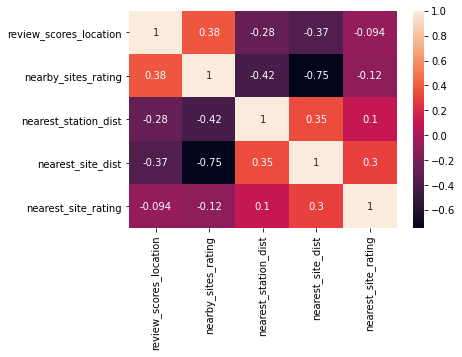

In [26]:
corrMatrix = df_location.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

As can be observed from above the `nearby site rating` is closely related to the `review score location`. And `review score location`is also negatively correlated with the `nearest site distance` and `nearest_station_dist`, which is reasonable because the further a location is to a station or a popular site, the worse its location tends to be.<br>

The conclusion is that among the factors that affect user review sentiments, `review_scores_location` plays **an insignificant role**, which means customers are **not so focused on** the location of the hotel. Specifically, the `location score` is **closely related to** the distance to nearby sites and MRT stations and the popularity of the sites.

# EDA - 5

Relationship between `Price`,`review_scores`, `sentiment_score` and `Neighbourhood_cleansed`, where `Neighbourhood_cleansed` means the summarized and cleansed version of the original neighborhood name.

In [7]:
# Transform the price attribute to numeric.
df.price = df.price.apply(lambda x:float(x.strip('$').replace(',',''))) 

In [8]:
df.price.describe()

count    155697.000000
mean        134.975915
std         138.050636
min           0.000000
25%          62.000000
50%         100.000000
75%         170.000000
max        9999.000000
Name: price, dtype: float64

As we can see from above, there are some **outliers** in price. Thus we decided to keep 99.5% of the price data for the sake of analysis.

In [9]:
df[df.price > df.price.quantile(0.995)].drop_duplicates(['listing_id']).price.describe()

count      92.000000
mean     1288.521739
std      1602.862683
min       601.000000
25%       659.750000
50%       773.000000
75%      1090.250000
max      9999.000000
Name: price, dtype: float64

In [29]:
df_cut = df[df.price <= df.price.quantile(0.995)]

In [30]:
# Extract the useful features.
df_price = df_cut[['price','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','neighbourhood_cleansed','polarity_score']]

In [31]:
keep_nbrhood = df_price.neighbourhood_cleansed.value_counts()[:-5]
df_price_keep = df_price[[x in keep_nbrhood for x in df_price.neighbourhood_cleansed]]

In [32]:
# Group all duplicate listings and keep their mean price.
df_price_nbr = df_price_keep.groupby(['neighbourhood_cleansed']).mean()

In [33]:
df_price_nbr

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,
Ang Mo Kio,83.281520,93.441125,9.581722,9.391916,9.938380,9.931459,9.035273,9.339789
Bedok,101.198945,94.213963,9.666150,9.548071,9.794683,9.793006,9.365256,9.410945
Bishan,77.375276,92.489433,9.450501,9.230256,9.705228,9.666296,9.219132,9.317019
Bukit Batok,73.030435,92.281752,9.421898,9.351825,9.676428,9.785401,9.049780,9.245974
Bukit Merah,146.157386,92.664457,9.556412,9.341091,9.721023,9.663379,9.505086,9.199753
Bukit Panjang,118.578447,90.480064,9.299841,9.138756,9.421053,9.599681,8.990431,9.154705
Bukit Timah,89.461673,92.718310,9.507489,9.272447,9.711894,9.759031,9.228634,9.329956
Central Water Catchment,83.296296,93.579439,9.411215,9.308411,9.971963,9.967290,9.359813,9.299065
Choa Chu Kang,111.585520,92.454216,9.452403,9.229374,9.465095,9.544878,9.135086,9.268359


In [148]:
df_price_nbr.sort_values(['polarity_score'],ascending=False)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Paya Lebar,45.000000,0.983600,60.000000,4.000000,2.000000,6.000000,10.000000,6.000000,6.000000
Southern Islands,223.177215,0.739707,96.798701,9.798701,9.857143,9.746753,9.792208,9.467532,9.337662
Sengkang,50.784215,0.719422,94.733953,9.922297,9.665541,9.789696,9.946791,8.879223,9.460304


In [27]:
df_price_nbr.sort_values(['review_scores_rating'],ascending=False)[:3]

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,
Southern Islands,223.910180,96.822086,9.791411,9.852761,9.742331,9.797546,9.453988,9.368098
Pasir Ris,115.605594,95.911765,9.820728,9.854342,9.809524,9.851541,9.425770,9.676471
Museum,352.637277,95.888331,9.728643,9.708543,9.880514,9.762702,9.928532,9.356784


Now we plot the price and relevant measures on the map.

In [20]:
# import our image 
singapore_img = mpimg.imread('../Pictures/sgshape.png')

In [21]:
# plot the data
def plotmap(df, attr):
    ax = df.plot(
        kind="scatter", 
        x="longitude", 
        y="latitude", 
        figsize=(20,14),
        c=attr, 
        cmap=plt.get_cmap("jet"),
        colorbar=True, 
        alpha=0.4,
    )

    plt.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.5)            

    plt.ylabel("Latitude", fontsize=20)
    plt.xlabel("Longitude", fontsize=20)

    plt.ylim(1.15, 1.50)
    plt.xlim(103.5, 104)
    plt.title('Price Variations with Locations')
    plt.show()

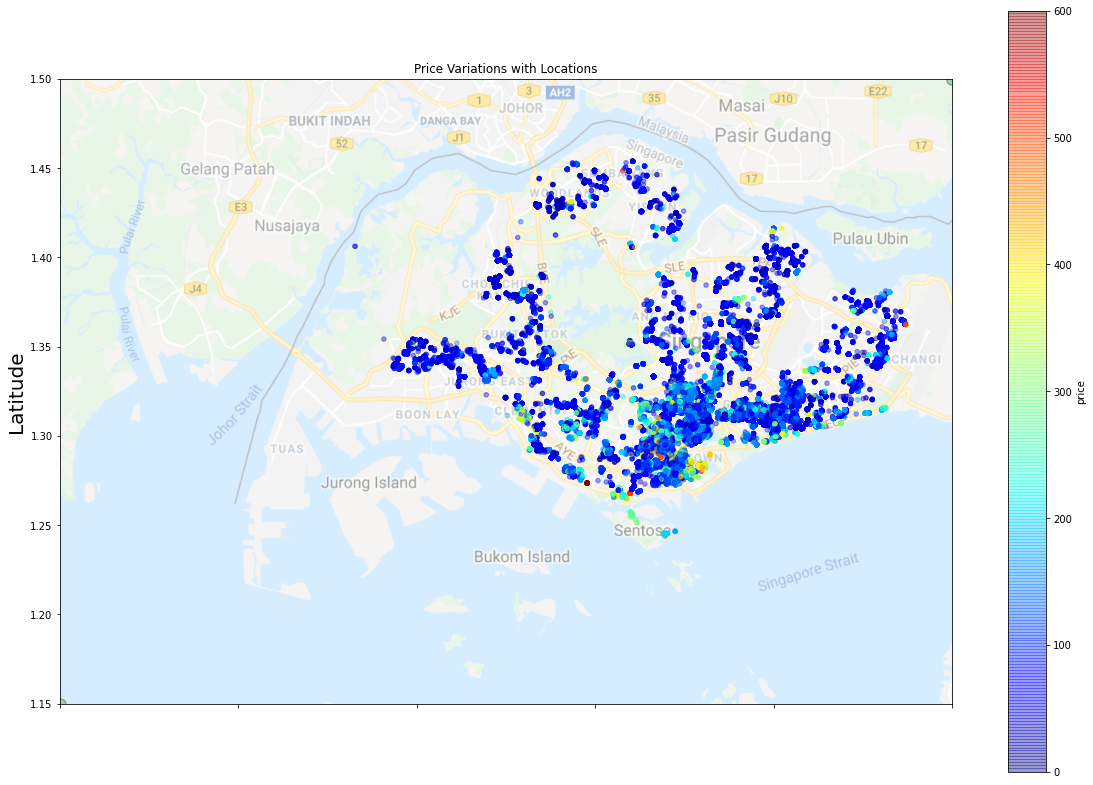

In [34]:
# Plot the relation of prices with geolocations
plotmap(df_cut, 'price')

In [38]:
df_price_nbr

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,
Ang Mo Kio,83.281520,93.441125,9.581722,9.391916,9.938380,9.931459,9.035273,9.339789
Bedok,101.198945,94.213963,9.666150,9.548071,9.794683,9.793006,9.365256,9.410945
Bishan,77.375276,92.489433,9.450501,9.230256,9.705228,9.666296,9.219132,9.317019
Bukit Batok,73.030435,92.281752,9.421898,9.351825,9.676428,9.785401,9.049780,9.245974
Bukit Merah,146.157386,92.664457,9.556412,9.341091,9.721023,9.663379,9.505086,9.199753
Bukit Panjang,118.578447,90.480064,9.299841,9.138756,9.421053,9.599681,8.990431,9.154705
Bukit Timah,89.461673,92.718310,9.507489,9.272447,9.711894,9.759031,9.228634,9.329956
Central Water Catchment,83.296296,93.579439,9.411215,9.308411,9.971963,9.967290,9.359813,9.299065
Choa Chu Kang,111.585520,92.454216,9.452403,9.229374,9.465095,9.544878,9.135086,9.268359


In [35]:
shapefile = '../Pictures/2014-planning-area/MP14_PLNG_AREA_NO_SEA_PL.shp'
map_nbr = gpd.read_file(shapefile)

In [36]:
df_price_map = df_price_nbr.reset_index()
df_price_map.neighbourhood_cleansed = df_price_map.neighbourhood_cleansed.str.upper()

merge_map = map_nbr.merge(df_price_map, left_on='PLN_AREA_N', right_on='neighbourhood_cleansed')
merge_map.reset_index(inplace=True)

In [37]:
merge_map

,index,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,...,geometry,neighbourhood_cleansed,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,...,"POLYGON ((30658.500 42047.527, 30679.195 42020...",ANG MO KIO,83.281520,93.441125,9.581722,9.391916,9.938380,9.931459,9.035273,9.339789
1,1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,...,"POLYGON ((38974.269 36138.243, 39371.471 35747...",BEDOK,101.198945,94.213963,9.666150,9.548071,9.794683,9.793006,9.365256,9.410945
2,2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,...,"POLYGON ((29772.191 38311.805, 29784.826 38304...",BISHAN,77.375276,92.489433,9.450501,9.230256,9.705228,9.666296,9.219132,9.317019
3,3,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,...,"POLYGON ((20294.455 39114.528, 20334.318 39054...",BUKIT BATOK,73.030435,92.281752,9.421898,9.351825,9.676428,9.785401,9.049780,9.245974
4,4,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,...,"POLYGON ((26228.631 30746.197, 26231.960 30743...",BUKIT MERAH,146.157386,92.664457,9.556412,9.341091,9.721023,9.663379,9.505086,9.199753
5,5,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,...,"POLYGON ((21448.724 41356.741, 21508.535 40890...",BUKIT PANJANG,118.578447,90.480064,9.299841,9.138756,9.421053,9.599681,8.990431,9.154705
6,6,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,...,"POLYGON ((24031.387 36694.742, 24076.658 36657...",BUKIT TIMAH,89.461673,92.718310,9.507489,9.272447,9.711894,9.759031,9.228634,9.329956
7,7,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,...,"POLYGON ((35619.754 32450.586, 35588.223 32427...",GEYLANG,120.121751,91.256030,9.413365,9.138224,9.642577,9.665564,9.041184,9.111842
8,8,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,...,"POLYGON ((31277.373 34723.293, 31305.947 34712...",KALLANG,121.278307,91.031304,9.374520,9.050217,9.626511,9.609882,9.368382,9.061562
9,9,11,NOVENA,NV,N,CENTRAL REGION,CR,916F55DE440B0D0E,2016-05-11,28221.5058,...,"POLYGON ((28297.100 35982.083, 28414.083 35789...",NOVENA,156.529899,91.681921,9.311782,9.138046,9.567825,9.526356,9.272356,9.060885


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

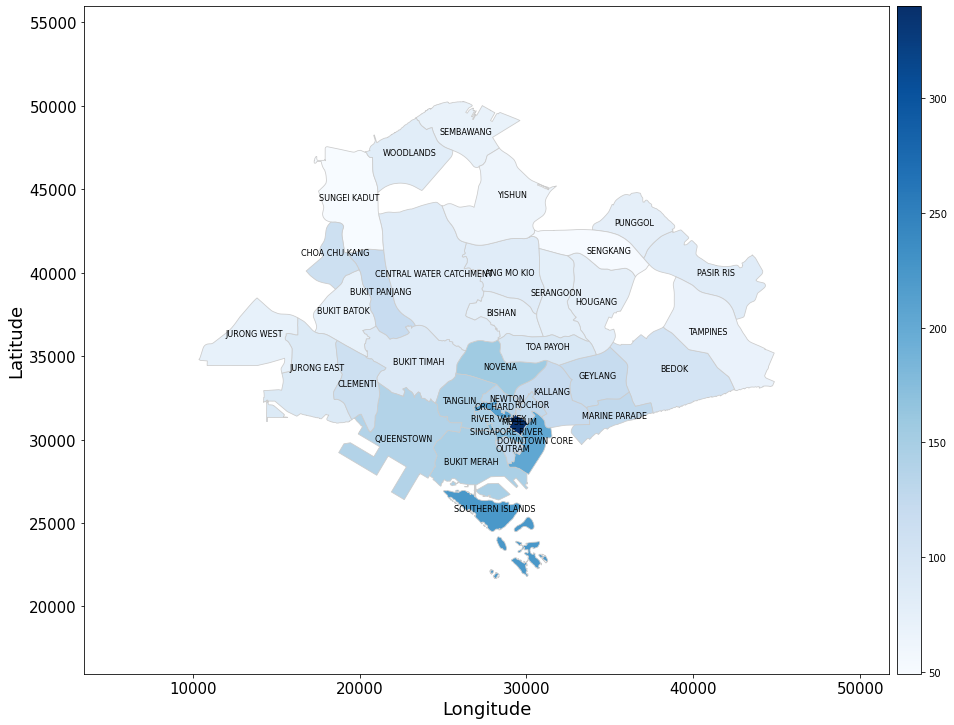

In [40]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=8)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='price',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')


# boston_neighb['polarity_bin'] = pd.qcut(boston_neighb['polarity'], q=5, precision=2)
# boston_neighb.plot(column='polarity_bin', cmap='Greens', figsize=(10,10), legend=True)

# sns.despine(top=True, right=True, left=True, bottom=True)
# plt.title('Average polarity per neighbourhood')

In [ ]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=8)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='polarity_score',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

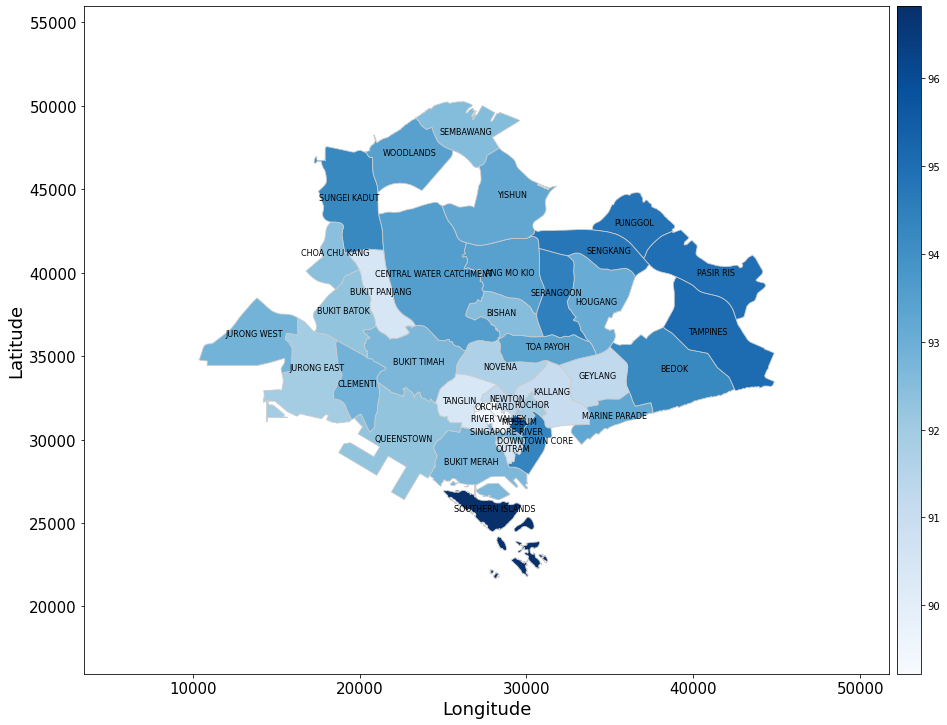

In [41]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=8)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='review_scores_rating',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')